In [103]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import joblib as jb
import math
import cv2
import matplotlib.patches as mpatches
import colorsys
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns

In [104]:
sns.set_style('darkgrid')

# Visualization - Bands and CSPM

In [6]:
data_path = 'generated/'
charts_path = 'generated/charts/'
maps_path = 'generated/maps/'
models_path = 'generated/models/'

# Load models

In [4]:
rf_model = jb.load(f'{models_path}rf_model.pkl.z')
lgbm_model = jb.load(f'{models_path}lgbm_model.pkl.z')
mlp_model = jb.load(f'{models_path}mlp_model.pkl.z')
xgboost_model = jb.load(f'{models_path}xgboost_model.pkl.z')
lr_model = jb.load(f'{models_path}lr_model.pkl.z')

In [11]:
df = jb.load(f'{data_path}dataset_dataframe.pkl.z')
df

,x,y,z,b1,b2,b3,b4,b5,b6,b7,b8,cspmb7,b2b4,b3b4,ndwi15,ndwi24,ndwi53
0,233,1130,3.195862,0.1199,0.0887,0.0692,0.0483,0.0518,0.0328,0.0315,0.0252,27.041417,1.156761,1.092734,0.396622,0.294890,-0.143802
1,233,1131,3.273030,0.1199,0.0886,0.0691,0.0484,0.0519,0.0335,0.0317,0.0254,27.274666,1.155853,1.091779,0.395809,0.293431,-0.142149
2,233,1132,3.299687,0.1199,0.0886,0.0690,0.0485,0.0519,0.0336,0.0320,0.0255,27.625527,1.155238,1.090825,0.395809,0.292487,-0.141439
3,233,1133,3.268182,0.1199,0.0885,0.0689,0.0484,0.0518,0.0336,0.0321,0.0256,27.742739,1.155562,1.091031,0.396622,0.292915,-0.141674
4,233,1134,3.278125,0.1199,0.0884,0.0688,0.0482,0.0517,0.0336,0.0321,0.0257,27.742739,1.156505,1.091822,0.397436,0.294290,-0.141909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19304,2293,86,2.264000,0.1262,0.1006,0.0789,0.0543,0.0466,0.0285,0.0270,0.0220,21.937274,1.154368,1.093542,0.460648,0.298903,-0.257371
19305,2294,86,1.909714,0.1256,0.1002,0.0785,0.0536,0.0452,0.0281,0.0267,0.0217,21.607165,1.157130,1.095829,0.470726,0.302991,-0.269200
19306,2295,86,1.539000,0.1256,0.0998,0.0782,0.0528,0.0447,0.0280,0.0265,0.0215,21.387827,1.160508,1.099019,0.475044,0.307995,-0.272579
19307,2295,87,1.360263,0.1256,0.1000,0.0783,0.0533,0.0454,0.0281,0.0267,0.0217,21.607165,1.158261,1.096735,0.469006,0.304631,-0.265966


In [218]:
columns = ['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8']

X_train, X_val, y_train, y_val = train_test_split(df[columns], df.z, test_size=0.3, random_state=42)

In [219]:
X_val = jb.load(f'{data_path}x_val.pkl.z')

In [220]:
base_image = cv2.imread(f'{maps_path}rgb_image.jpg')

In [221]:
transects_image = base_image.copy()
for i, row in enumerate(df.itertuples()):
    x = row.x
    y = row.y
    transects_image = cv2.circle(transects_image,(x,y),4,[255,255,255],4)
cv2.imwrite(f'{maps_path}bat_transects.jpg',transects_image)

True

In [318]:
# dataframe requires: x, y, error
def draw_abs_error_image(rgb_base, dataframe, prefix, divisor=30):
    result_image = rgb_base.copy()
    for i, row in enumerate(dataframe.itertuples()):
        x = int(row.x)
        y = int(row.y)
        abs_error = row.abs_error
        result_image = cv2.circle(result_image,(x,y),5,[int(e*255) for e in (colorsys.hls_to_rgb(min(0.8,abs_error/float(divisor)), 0.5, 1))],6)
        #abs_error_image[y][x] = [int(e*255) for e in (colorsys.hls_to_rgb(abs_error/(df_data['abs_error'].max()*1.2), 0.5, 1))]

    result = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)
    result_label = insert_label(result,'Error',divisor)
    cv2.imwrite(f'{maps_path}{prefix}_abs_error.jpg',result_label)
    

In [319]:
# dataframe requires: x, y, z or predict
def draw_depth_image(rgb_base, dataframe, prefix, isbat=True, divisor=30):
    result_image = rgb_base.copy()
    for i, row in enumerate(dataframe.itertuples()):
        x = int(row.x)
        y = int(row.y)
        depth = 0
        if isbat:
            depth = row.z
        else:
            depth = row.prediction
        
        result_image = cv2.circle(result_image,(x,y),5,[int(e*255) for e in (colorsys.hls_to_rgb(min(0.8,depth/float(divisor)), 0.5, 1))],5)
        #abs_error_image[y][x] = [int(e*255) for e in (colorsys.hls_to_rgb(abs_error/(df_data['abs_error'].max()*1.2), 0.5, 1))]

    result = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)
    result_label = insert_label(result,'Depth',divisor)
    cv2.imwrite(f'{maps_path}{"bat" if isbat else prefix}_depth.jpg',result_label)

In [224]:
prediction = rf_model.predict(df[columns])
prediction_val = rf_model.predict(X_val)

In [225]:
dfpred = df[['x','y','z']].copy()
dfpred['prediction'] = prediction
dfpred['abs_error'] = abs(dfpred['prediction'] - dfpred['z'])

In [226]:
dfpred['abs_error'].describe()

count    18275.000000
mean         0.305313
std          0.611557
min          0.000013
25%          0.029955
50%          0.103822
75%          0.311727
max         13.424996
Name: abs_error, dtype: float64

In [320]:
draw_abs_error_image(base_image,dfpred,'rf',10)

In [321]:
draw_depth_image(base_image,dfpred,'rf',False)#rf

In [322]:
draw_depth_image(base_image,dfpred,'bat')#bat

In [230]:
df_bat = jb.load(f'{data_path}bat_dataframe.pkl.z')
df_bat

,x,y,z
0,236.782,1016.283,1.96
1,236.795,1016.285,1.98
2,236.807,1016.288,1.98
3,236.819,1016.291,1.97
4,236.831,1016.293,1.98
...,...,...,...
533307,618.304,0.091,7.93
533308,618.339,0.070,7.93
533309,618.375,0.049,7.93
533310,618.412,0.029,7.93


In [231]:
def find_transect(x_s, y_s, x_e, y_e, df):
    transect = list()
    angle = math.atan2(y_s-y_e, x_s-x_e)
    low_x, high_x = (x_s, x_e) if x_s < x_e else (x_e, x_s)
    low_y, high_y = (y_s, y_e) if y_s < y_e else (y_e, y_s)
    df_t = df[(df['x'] >= low_x) & (df['x'] <= high_x)]
    df_t = df_t[(df_t['y'] >= low_y) & (df_t['y'] <= high_y)]
    for row in df_t.itertuples():
        x = row.x 
        y = row.y
        angle2 = math.atan2(y-y_e,x-x_e)
        #math.atan2(y-y_s,x-x_s)
        if abs(angle2 - angle) < 0.05:
            transect.append(row)
    return transect
    

In [246]:
def generate_transect_charts(dfprediction, df_bat, df_val, transect_coords, charts_path, maps_path, base_image, prefix):
    transect = find_transect(coords[0],coords[1],coords[2],coords[3],dfprediction)
    bat_transect = find_transect(coords[0],coords[1],coords[2],coords[3],df_bat)
    
    if base_image is not None:
        transect_image = base_image.copy()
        for i, row in enumerate(transect):
            x = row.x
            y = row.y
            transect_image = cv2.circle(transect_image,(x,y),5,[0,255,0],5)

        cv2.imwrite(f'{maps_path}bat_single_transect_{coords[0]}_{coords[1]}.jpg',transect_image)
        
    df_transect = pd.DataFrame(transect)
    df_transect.drop(['Index'], axis=1, inplace=True)
    
    df_transect_bat = pd.DataFrame(bat_transect)
    df_transect_bat.drop(['Index'], axis=1, inplace=True)
    
    plt.figure(figsize=(15,8))
    plt.plot(df_transect_bat['x'],-df_transect_bat['z'], 'c.',
             df_transect['x'],-df_transect['z'], 'b.')
    a = mpatches.Patch(color='c', label='Bathymetry')
    b = mpatches.Patch(color='b', label='Bathymetry Pixel')
    plt.legend(handles=[a,b])
    plt.xlabel("X Pixel Coord")
    plt.ylabel("Depth(m)")
    plt.savefig(f'{charts_path}{prefix}_chart_bat_pixel_{coords[0]}_{coords[1]}.jpg')
    
    plt.figure(figsize=(15,8))
    plt.plot(df_transect_bat['x'],-df_transect_bat['z'], 'c.',
             df_transect['x'],-df_transect['prediction'], 'm.')
    a = mpatches.Patch(color='c', label='Bathymetry')
    b = mpatches.Patch(color='m', label='Prediction All')
    plt.legend(handles=[a,b])
    plt.xlabel("X Pixel Coord")
    plt.ylabel("Depth(m)")
    plt.savefig(f'{charts_path}{prefix}_chart_bat_pred_{coords[0]}_{coords[1]}.jpg')
    
    plt.figure(figsize=(15,8))
    plt.plot(df_transect_bat['x'],-df_transect_bat['z'], 'c.',
             df_transect[df_transect.index.isin(df_val.index)]['x'],-df_transect[df_transect.index.isin(df_val.index)]['prediction'], 'r.')
    a = mpatches.Patch(color='c', label='Bathymetry')
    b = mpatches.Patch(color='r', label='Prediction Val')
    plt.legend(handles=[a,b])
    plt.xlabel("X Pixel Coord")
    plt.ylabel("Depth(m)")
    plt.savefig(f'{charts_path}{prefix}_chart_bat_pred_val_{coords[0]}_{coords[1]}.jpg')

In [241]:
transect_coords = [[510,410,680,310],
                   [1604,142,1772,440],
                   [871,1123,1190,939],
                   [1020,705,1319,532],
                   [706,1338,1028,1149],
                   [1366,935,1130,523],
                   [1081,1090,1020,983]]
                   #[494,417,689,303],
                   #[510,294,617,233]]

#p2: 706 1338, 1028 1149
#p3: 1366 935, 1130 523
#p4: 1081 1090, 1020 983
#p5: 494 417, 689 303

C:\Users\ricar\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


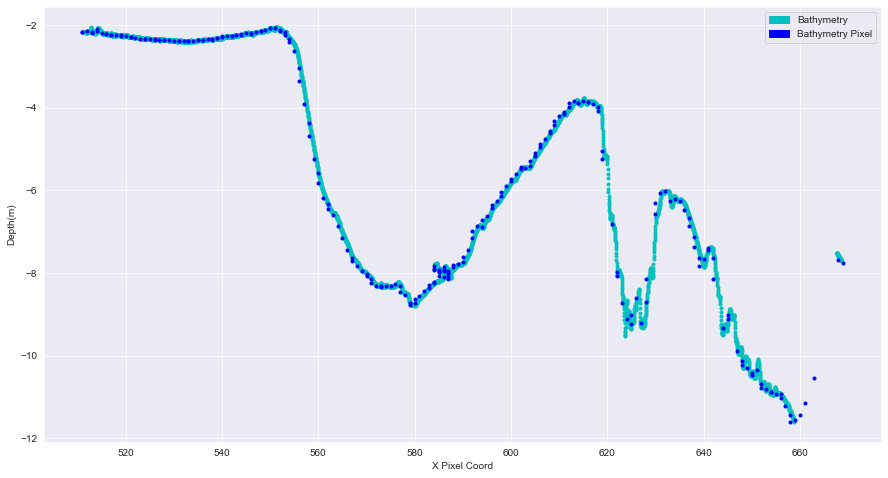

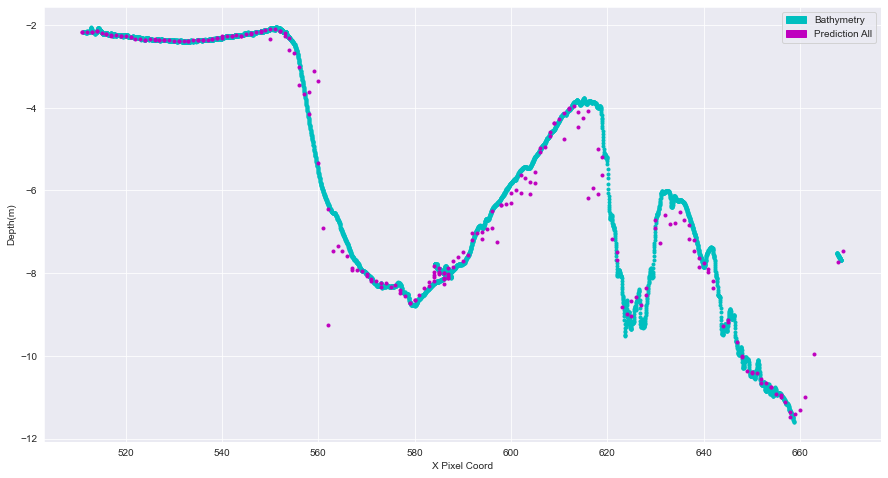

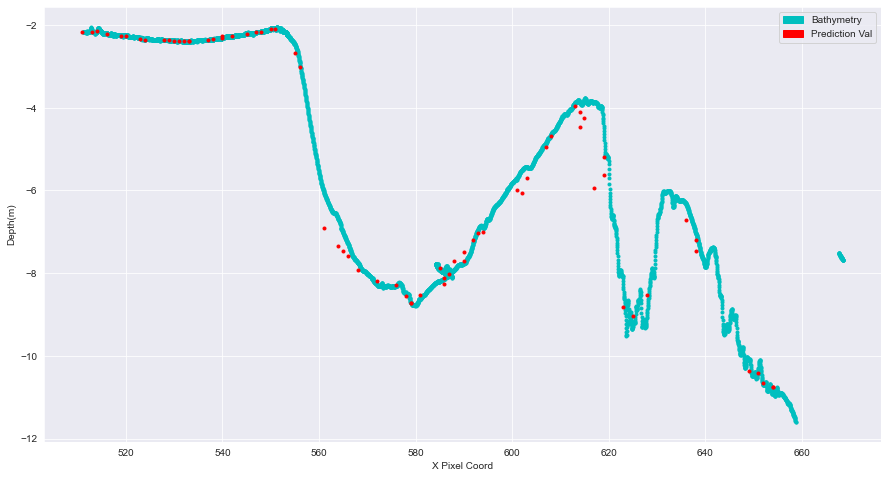

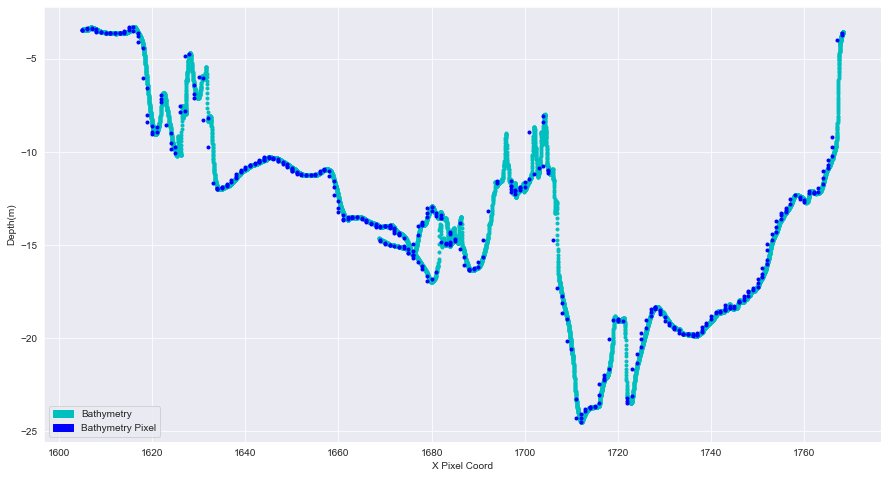

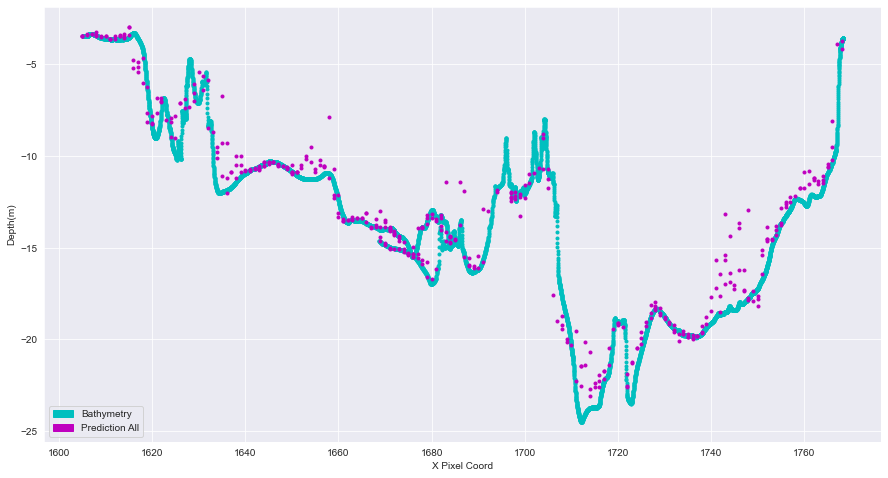

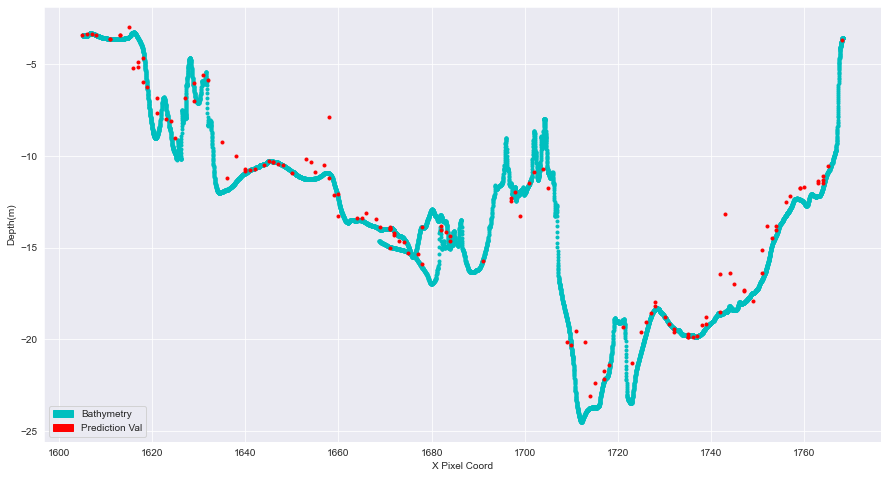

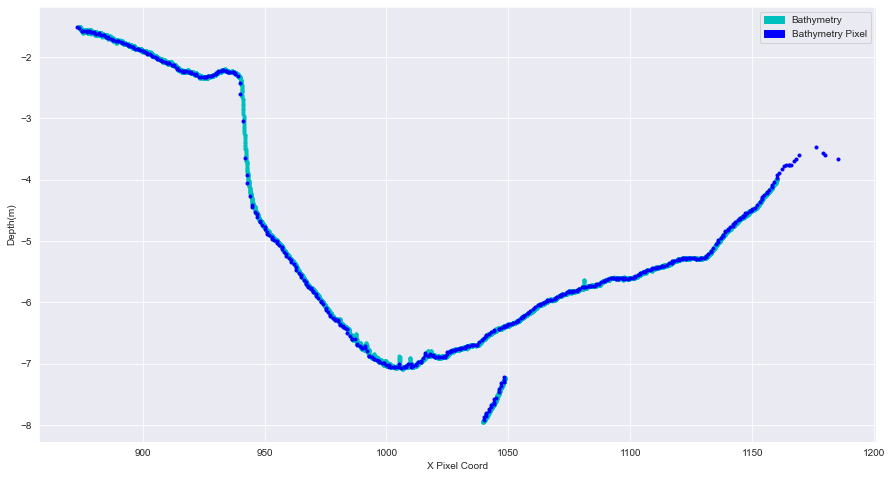

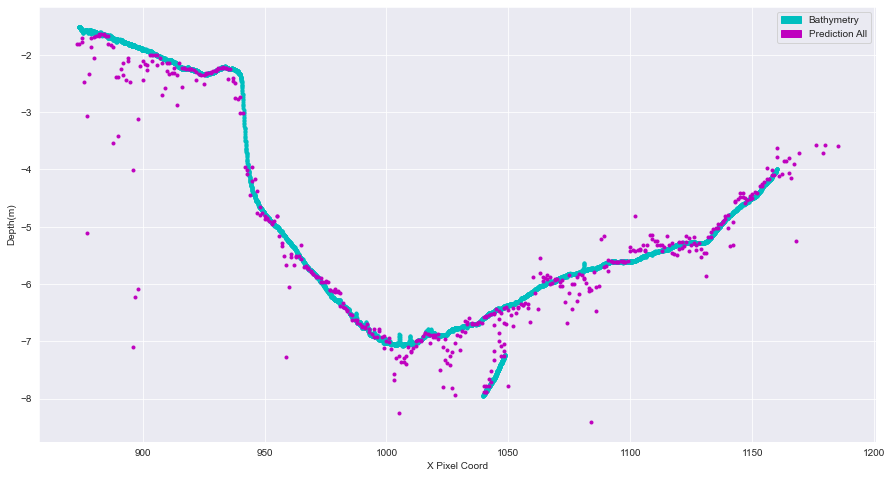

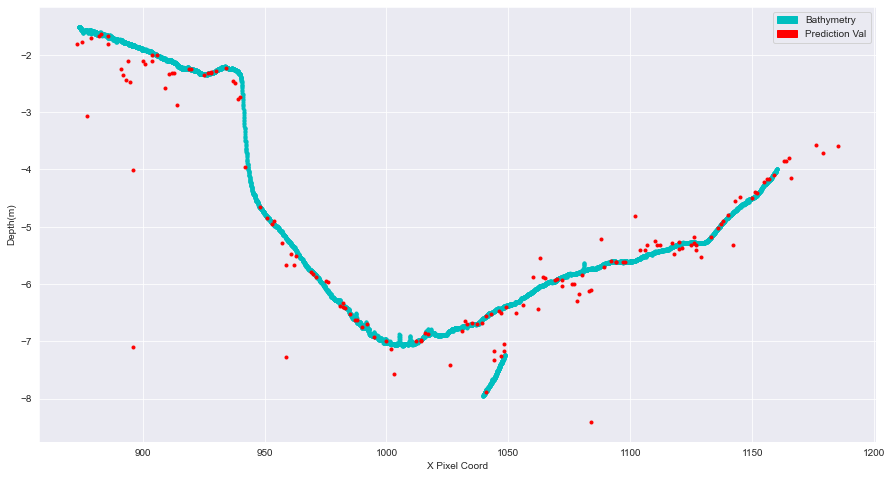

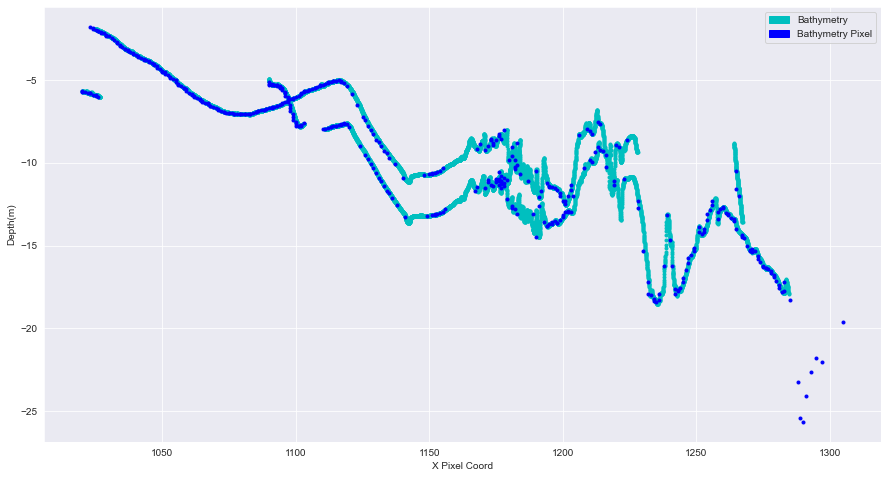

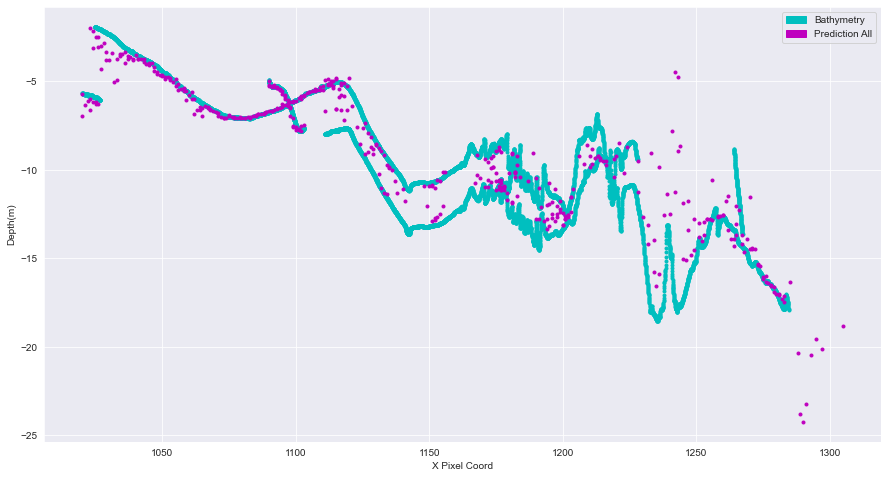

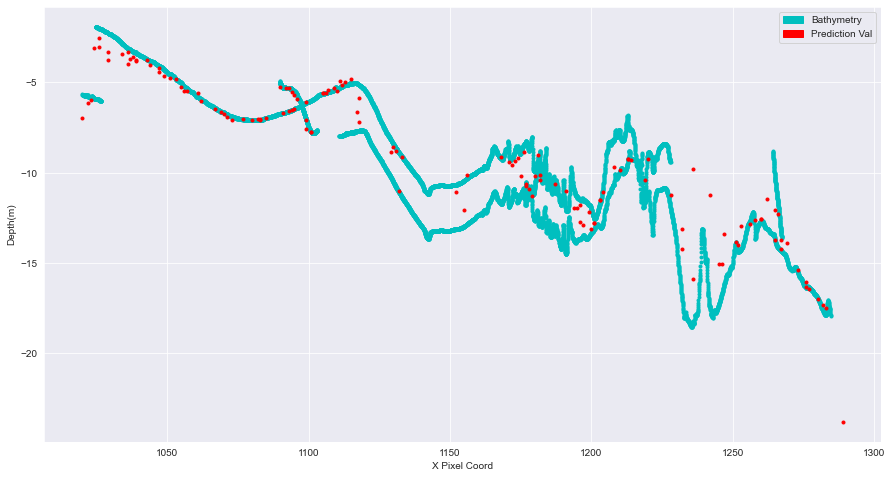

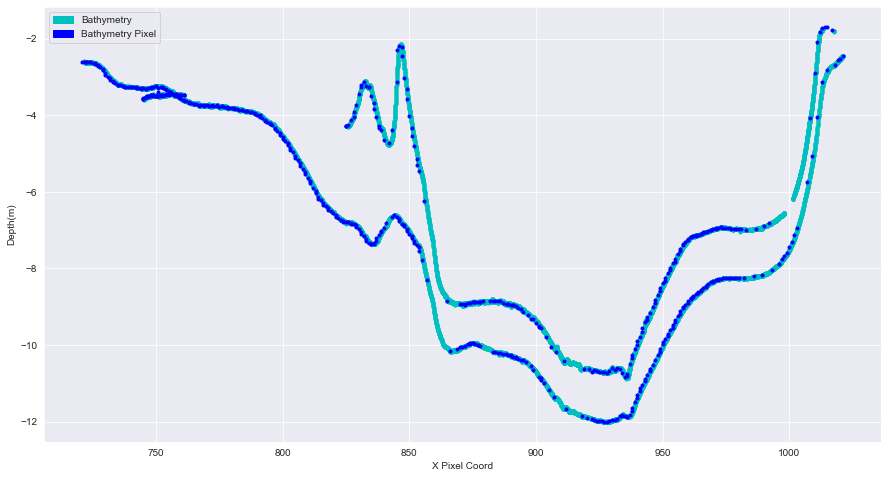

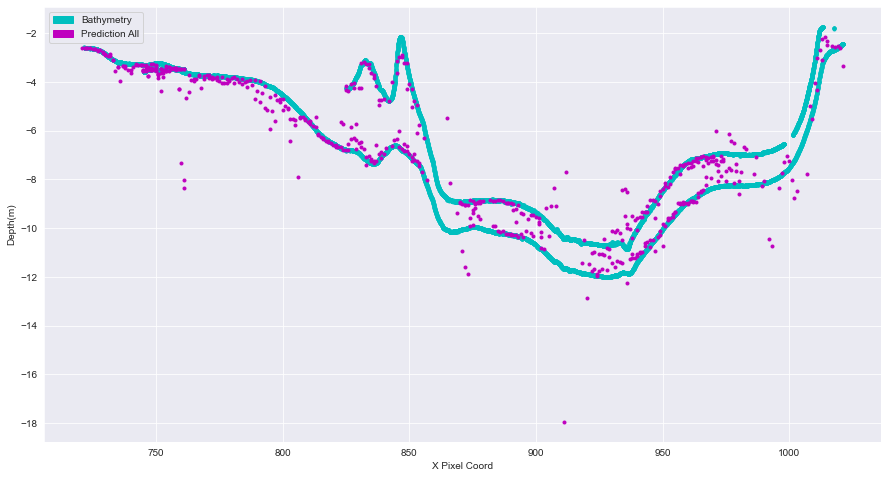

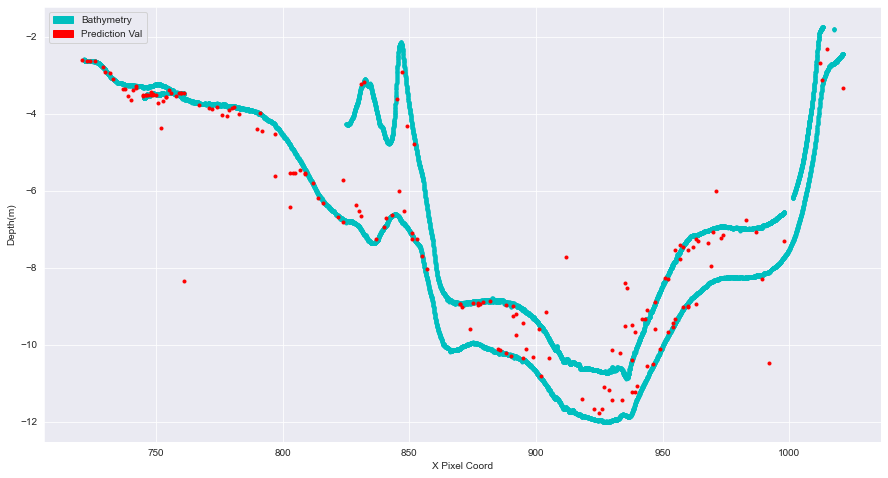

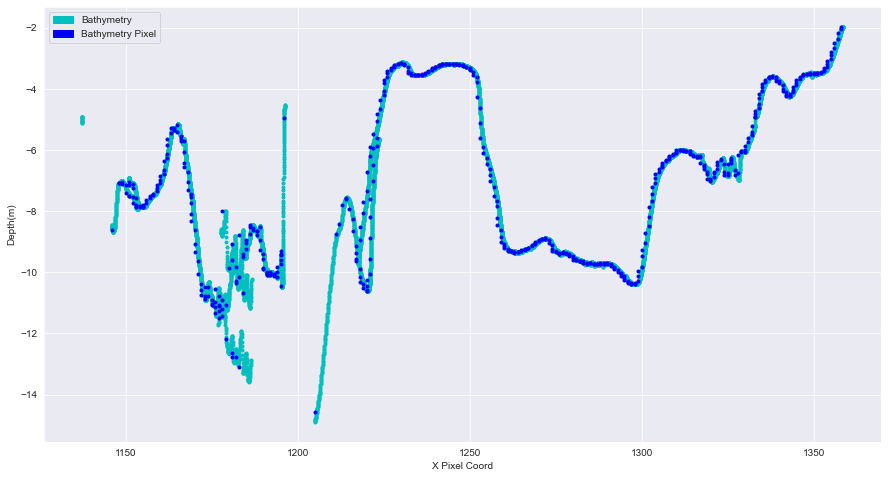

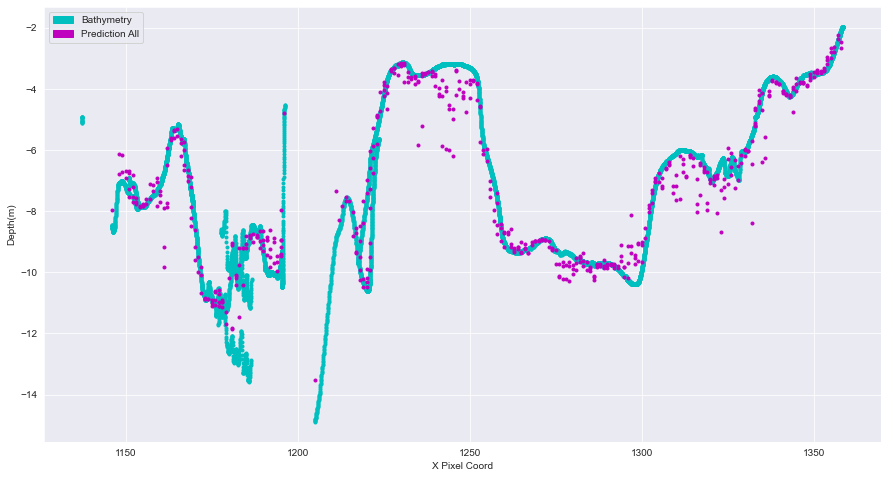

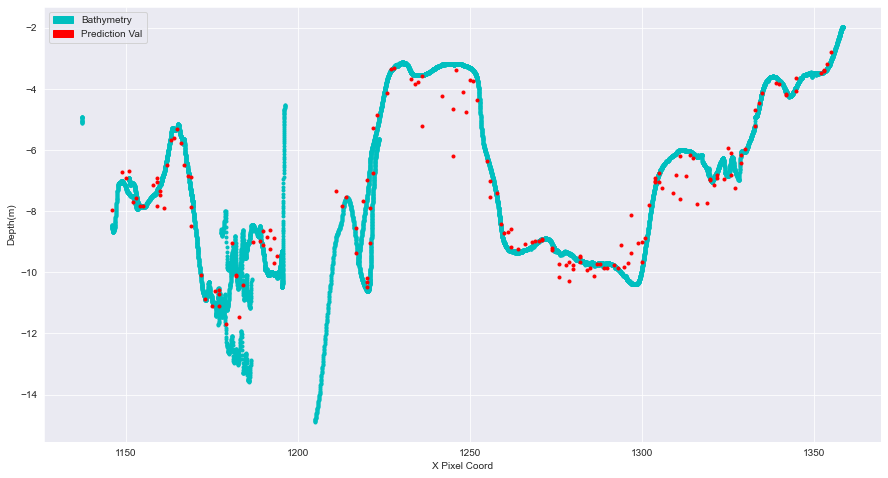

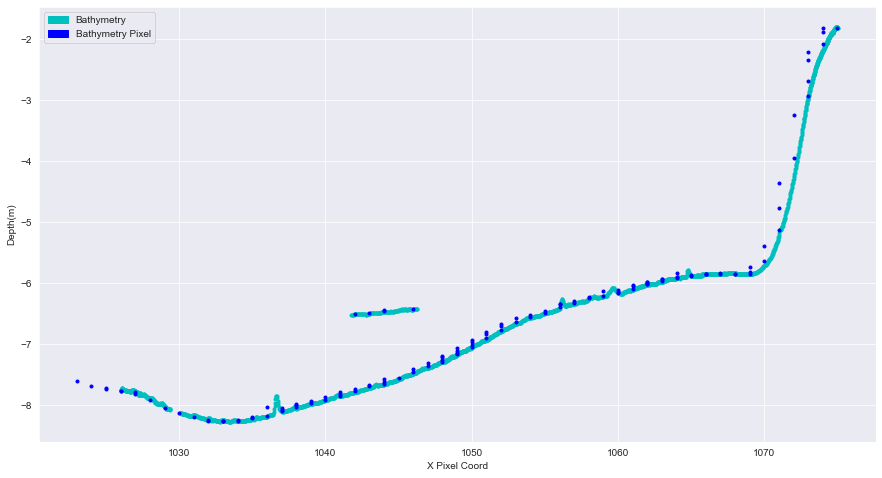

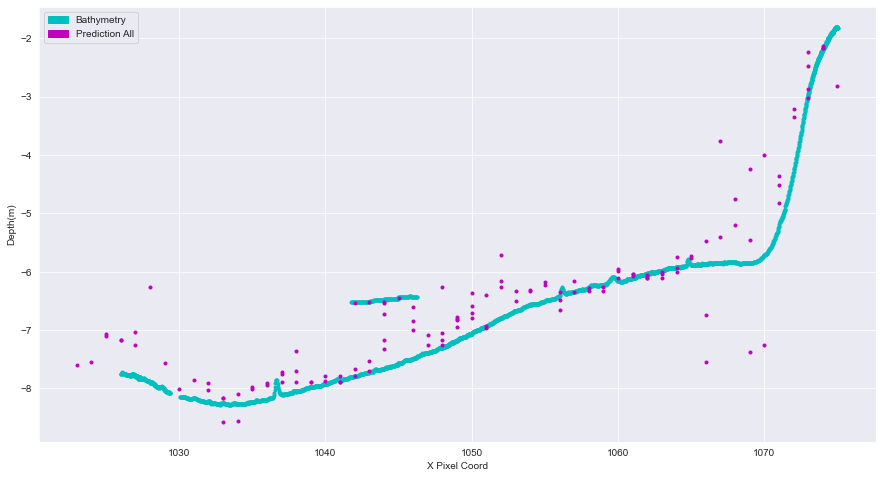

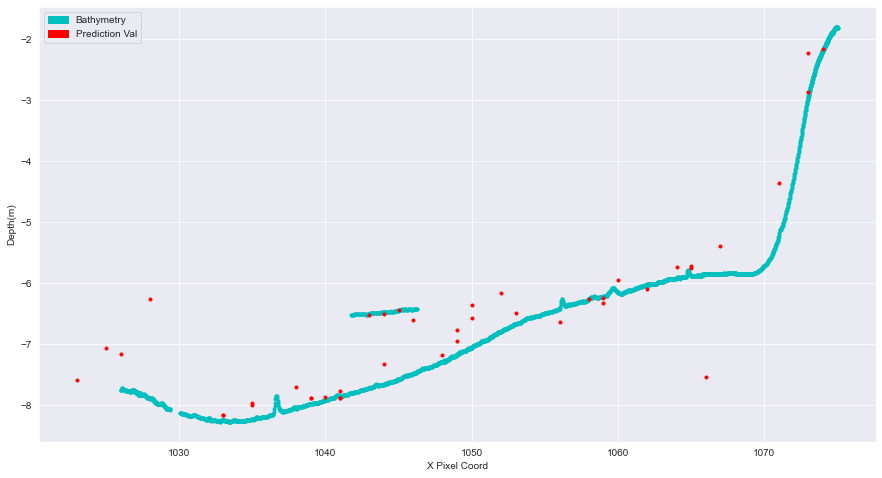

In [242]:
plt.grid
for i, coords in enumerate(transect_coords):
    generate_transect_charts(dfpred, df_bat, X_val, coords, charts_path, maps_path, base_image, 'rf')

In [314]:
def insert_label(image,label,max_depth_value=30):
    frame = image.copy()
    posx = 0.80
    posy = 0.5
    height = 0.4
    width = 0.15
    spacing = 5
    intervals = 10

    h = int(image.shape[0]*height)
    w = int(image.shape[1]*width)
    x = int(image.shape[1]*posx)
    y = int(image.shape[0]*posy)
    cv2.rectangle(frame, (x, y), (x+w,y+h), (255, 255, 255), -1)

    cv2.rectangle(frame, (x, y-300), (x+w,y), (255, 255, 255), -1)


    font = cv2.FONT_HERSHEY_COMPLEX
    fontScale = 3
    color = (0, 0, 0)
    thickness = 4
    pos = (x+50, y-180)
    cv2.putText(frame, label, pos, font, fontScale, color, thickness, cv2.LINE_AA)
    pos = (x+50, y-100)
    fontScale = 2
    cv2.putText(frame, "(meters)", pos, font, fontScale, color, thickness, cv2.LINE_AA)

    fontScale = 2
    for i in range(intervals+1):
        pos = (x+250, y-15+int(i*h/intervals))
        cv2.putText(frame, str(i*max_depth_value/float(intervals)), pos, font, fontScale, color, thickness, cv2.LINE_AA)

    iterations = max_depth_value*100
    for i in range(iterations):
        color = [int(e*255) for e in (colorsys.hls_to_rgb(0.8*((i)/100)/max_depth_value, 0.5, 1))]
        cv2.rectangle(frame, (x+50, y-40+int(h*(i/iterations))), (x+int(w/2.5),y-40+int(h*(i/iterations))+1), color[::-1], -1)

    return frame